# Reading Shapefiles from a URL into GeoPandas

Shapefiles are probably the most commonly used vector geospatial data format. However, because a single Shapefile consists of multiple files (at least 3 and up to 15) they are often transferred as a single zip file. In this post I demonstrate how to read a zipped shapefile from a server into a GeoPandas GeoDataFrame (with coordinate reference system information), all in memory.

We read geospatial data from the web

We read U.S. County geographic boundaries from the [Census FTP site](http://www2.census.gov).

adapted from: http://andrewgaidus.com/Reading_Zipped_Shapefiles/

In [24]:
from zipfile import ZipFile
import geopandas as gpd
from shapely.geometry import shape  
import osr
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [25]:
! pip install pyshp

In [26]:
import shapefile

In [27]:
import sys
print("The Python version is %s.%s.%s" % sys.version_info[:3])

The Python version is 3.7.7


# Use  conda install -c conda-forge gdal

The first step is to use ```PyShp``` to read in our Shapefile. If we were just reading a Shapefile from disk we would simply call: 

```
r = shapefile.Reader("myshp.shp")
```

However, because we are reading our Shapefile from a zipfile, we will need to specify the individual components of this file. Unfortunately, we can't read the contents of a zipfile directly into Python from the URL. While we could have Python download the file to disk and then read it in from there, I want to demonstrate how this can be done all in memory without any disk activity. Therefore we need to take an additional step where the data from the URL is read into a ```StringIO``` object, which is in turn read by Python as a zip file. The ```StringIO``` object is just an intermediate data type between the data read in from the URL and the zip file in Python. This is done in one line of code below:

In [28]:
import geopandas as gpd
import requests
import zipfile
import io
import matplotlib.pyplot as plt
%matplotlib inline 

In [29]:
print(gpd.__version__)

0.7.0


In [30]:
url = 'http://www2.census.gov/geo/tiger/GENZ2015/shp/cb_2015_us_county_500k.zip'
local_path = 'tmp/'
print('Downloading shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

Done
['cb_2015_us_county_500k.dbf', 'cb_2015_us_county_500k.prj', 'cb_2015_us_county_500k.shp', 'cb_2015_us_county_500k.shx']


In [31]:
dbf, prj, shp, shx = [filename for filename in filenames]
usa = gpd.read_file(local_path + shp)
print("Shape of the dataframe: {}".format(usa.shape))
print("Projection of dataframe: {}".format(usa.crs))
usa.tail() #last 5 records in dataframe

Shape of the dataframe: (3233, 10)
Projection of dataframe: epsg:4269


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
3228,45,019,01252740,0500000US45019,45019,Charleston,06,2372842394,1144346152,"MULTIPOLYGON (((-79.50795 33.02008, -79.50713 ..."
3229,45,077,01248015,0500000US45077,45077,Pickens,06,1285536060,40612589,"MULTIPOLYGON (((-82.86687 34.61742, -82.86451 ..."
3230,46,123,01265784,0500000US46123,46123,Tripp,06,4176233698,13272785,"POLYGON ((-100.23091 43.49989, -100.23044 43.5..."
3231,47,073,01639752,0500000US47073,47073,Hawkins,06,1261443215,32545400,"POLYGON ((-83.28890 36.37879, -83.28250 36.382..."
3232,48,011,01383791,0500000US48011,48011,Armstrong,06,2354581764,12219587,"POLYGON ((-101.62940 34.75006, -101.62806 34.8..."


Now this zipfile object can be treated as any other zipfile that was read in from disk. Below I identify the filenames of the 4 necessary components of the Shapefile. Note that the ```prj``` file is actually not 100% necessary, but in contains the coordinate reference system information which is really nice to have, and will be used below.

In [32]:
print(len(usa))

3233


In [33]:
nj = usa[usa.STATEFP=='44']

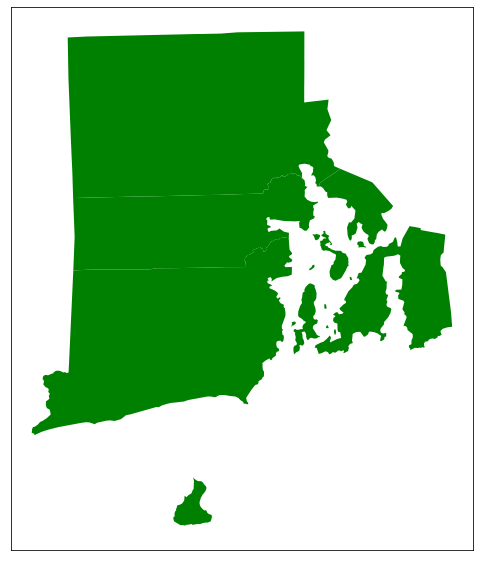

In [34]:
ax = nj.plot(color = 'green', figsize=(10,10),linewidth=2)
ax.set(xticks=[], yticks=[])
plt.savefig("NJ_Counties.png", bbox_inches='tight')

In [35]:
print(nj.head())

     STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID        NAME LSAD  \
645       44      009  01219782  0500000US44009  44009  Washington   06   
724       44      005  01219779  0500000US44005  44005     Newport   06   
871       44      007  01219781  0500000US44007  44007  Providence   06   
1514      44      001  01219777  0500000US44001  44001     Bristol   06   
2106      44      003  01219778  0500000US44003  44003        Kent   06   

           ALAND     AWATER                                           geometry  
645    852834829  604715929  MULTIPOLYGON (((-71.61313 41.16028, -71.61053 ...  
724    265220482  546983257  MULTIPOLYGON (((-71.28802 41.64558, -71.28647 ...  
871   1060637931   67704263  POLYGON ((-71.79924 42.00806, -71.76601 42.009...  
1514    62550804   53350670  POLYGON ((-71.35390 41.75130, -71.34718 41.756...  
2106   436515567   50720026  POLYGON ((-71.78967 41.72457, -71.75435 41.725...  


## Modify here to extract census tracts of CA

In [36]:
url = 'http://www2.census.gov/geo/tiger/GENZ2015/shp/cb_2015_06_tract_500k.zip'
local_path = 'tmp/'
print('Downloading shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

Done
['cb_2015_06_tract_500k.dbf', 'cb_2015_06_tract_500k.prj', 'cb_2015_06_tract_500k.shp', 'cb_2015_06_tract_500k.shx']


In [37]:
dbf, prj, shp, shx = [filename for filename in filenames]
usa = gpd.read_file(local_path + shp)
print("Shape of the dataframe: {}".format(usa.shape))
print("Projection of dataframe: {}".format(usa.crs))
usa.tail() #last 5 records in dataframe

Shape of the dataframe: (8043, 10)
Projection of dataframe: epsg:4269


,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
8038,06,067,007426,1400000US06067007426,06067007426,74.26,CT,868096,0,"POLYGON ((-121.38701 38.71209, -121.38563 38.7..."
8039,06,113,010203,1400000US06113010203,06113010203,102.03,CT,10247745,756079,"POLYGON ((-121.58346 38.57860, -121.58277 38.5..."
8040,06,073,018611,1400000US06073018611,06073018611,186.11,CT,24598731,92324,"POLYGON ((-117.29814 33.26156, -117.29753 33.2..."
8041,06,059,110301,1400000US06059110301,06059110301,1103.01,CT,1835530,0,"POLYGON ((-118.03749 33.85865, -118.03315 33.8..."
8042,06,061,021122,1400000US06061021122,06061021122,211.22,CT,3119506,0,"POLYGON ((-121.25720 38.82472, -121.25450 38.8..."


In [38]:
len(usa)

8043

In [39]:
alameda = usa[usa.COUNTYFP=='001']

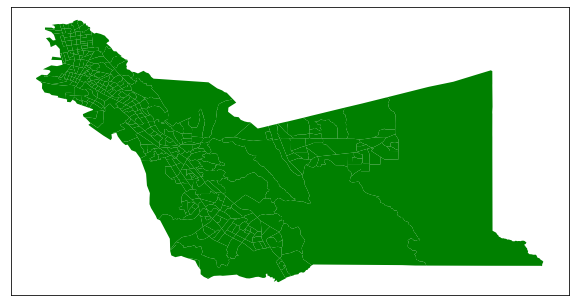

In [40]:
ax = alameda.plot(color = 'green', figsize=(10,10),linewidth=2)
ax.set(xticks=[], yticks=[])
plt.savefig("ALAMEDA_tracts.png", bbox_inches='tight')

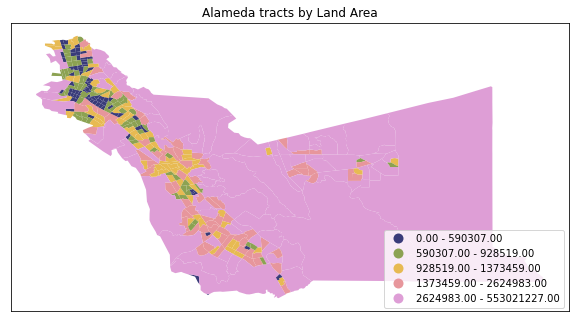

In [41]:
ax = alameda.plot(figsize=(10,10), column='ALAND', cmap="tab20b", scheme='quantiles', legend=True)
ax.set(xticks=[], yticks=[]) #removes axes
ax.set_title("Alameda tracts by Land Area", fontsize='large')
#add the legend and specify its location
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.0,0.3))
plt.savefig("Alameda_tracts.png", bbox_inches='tight')

In [42]:
alameda_tract_geo = alameda[alameda.COUNTYFP=='001']
#alameda_tract_geo = alameda.set_index("GEOID")['geometry'].to_crs(epsg=3310)

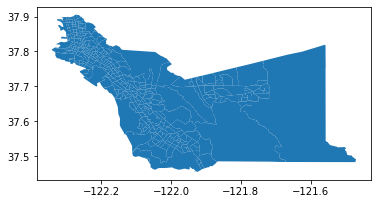

In [43]:
alameda_tract_geo.plot()

In [44]:
alameda_tract_geo.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,001,400600,1400000US06001400600,06001400600,4006,CT,297856,0,"POLYGON ((-122.26807 37.84414, -122.26514 37.8..."
1,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,"POLYGON ((-122.28558 37.83978, -122.28319 37.8..."
2,06,001,401400,1400000US06001401400,06001401400,4014,CT,758241,0,"POLYGON ((-122.27861 37.82688, -122.26856 37.8..."
3,06,001,403000,1400000US06001403000,06001403000,4030,CT,352394,0,"POLYGON ((-122.27476 37.79883, -122.27127 37.8..."
4,06,001,405902,1400000US06001405902,06001405902,4059.02,CT,487280,0,"POLYGON ((-122.24717 37.78991, -122.24351 37.7..."


In [45]:
#current coordinate dataframe
print(alameda_tract_geo.crs)

epsg:4269


In [46]:
alameda_tract_geo['geometry'].head()

0    POLYGON ((-122.26807 37.84414, -122.26514 37.8...
1    POLYGON ((-122.28558 37.83978, -122.28319 37.8...
2    POLYGON ((-122.27861 37.82688, -122.26856 37.8...
3    POLYGON ((-122.27476 37.79883, -122.27127 37.8...
4    POLYGON ((-122.24717 37.78991, -122.24351 37.7...
Name: geometry, dtype: geometry

Create an empty column alameda_tract_geo['income'] = None

In [48]:
alameda_tract_geo['income'] = None

Get a census API KEY here: https://api.census.gov/data/key_signup.html

Tutorial in Geopandas dataframes here https://github.com/Automating-GIS-processes/Lesson-2-Geo-DataFrames/blob/master/Lesson/pandas-geopandas.md

## Here we work with the Census Tracts of Alameda County

In [49]:
from census import Census
from us import states
import csv

In [50]:
MY_API_KEY=''
c = Census(MY_API_KEY)
c.acs5.get(('NAME', 'B19013_001E'),
          {'for': 'state:{}'.format(states.CA.fips)})   

[{'NAME': 'California', 'B19013_001E': 67169.0, 'state': '06'}]

In [51]:
request = c.acs5.state_county_tract('B19013_001E', '06', '001', Census.ALL)

In [52]:
data = json.loads(str(request).replace("'",'"'))
f = csv.writer(open("income.csv", "w"))

In [53]:
alameda_tract_geo['income'] = None

In [54]:
for index, row in alameda_tract_geo.iterrows():
    # Update the value in 'area' column with area information at index
    poly_area = row['geometry'].area
    # Print information for the user
    temp2=row['GEOID']
    #print("Polygon area at index {0} is: {1:.6f}".format(index, poly_area),'',temp2)
    for line in request:
        temp=line["state"]+line["county"]+line["tract"];
        if(temp==temp2):
            print(temp,' ',temp2,' ',line["B19013_001E"]);
            if line["B19013_001E"] > 0: 
                alameda_tract_geo.loc[index, 'income']=line["B19013_001E"]
            else:
                alameda_tract_geo.loc[index, 'income']=0.0

06001400600   06001400600   86458.0
06001400900   06001400900   57011.0
06001401400   06001401400   30479.0
06001403000   06001403000   22711.0
06001405902   06001405902   36000.0
06001407102   06001407102   52383.0
06001409500   06001409500   33963.0
06001421400   06001421400   146774.0
06001422900   06001422900   22399.0
06001424001   06001424001   71392.0
06001427900   06001427900   93071.0
06001430800   06001430800   81133.0
06001432600   06001432600   56404.0
06001433900   06001433900   42363.0
06001436100   06001436100   78870.0
06001437300   06001437300   73625.0
06001440304   06001440304   85417.0
06001440335   06001440335   137265.0
06001441602   06001441602   103588.0
06001442100   06001442100   175417.0
06001443322   06001443322   150132.0
06001450604   06001450604   146573.0
06001451503   06001451503   106333.0
06001451505   06001451505   153194.0
06001402600   06001402600   21250.0
06001402700   06001402700   59688.0
06001402900   06001402900   26786.0
06001403701   060014

06001408500   06001408500   47333.0
06001435400   06001435400   55649.0
06001405000   06001405000   128125.0
06001433200   06001433200   43682.0
06001441302   06001441302   115673.0
06001441926   06001441926   88704.0
06001444301   06001444301   106103.0


In [58]:
alameda_tract_geo.tail()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,income
7867,06,001,405000,1400000US06001405000,06001405000,4050,CT,800378,0,"POLYGON ((-122.24329 37.81105, -122.23720 37.8...",128125
7868,06,001,433200,1400000US06001433200,06001433200,4332,CT,3174901,0,"POLYGON ((-122.16667 37.71042, -122.15559 37.7...",43682
7869,06,001,441302,1400000US06001441302,06001441302,4413.02,CT,1994667,0,"POLYGON ((-122.02680 37.57692, -122.02536 37.5...",115673
7900,06,001,441926,1400000US06001441926,06001441926,4419.26,CT,408690,0,"POLYGON ((-121.98076 37.54461, -121.97682 37.5...",88704
7977,06,001,444301,1400000US06001444301,06001444301,4443.01,CT,2576474,0,"POLYGON ((-122.06733 37.54023, -122.06448 37.5...",106103


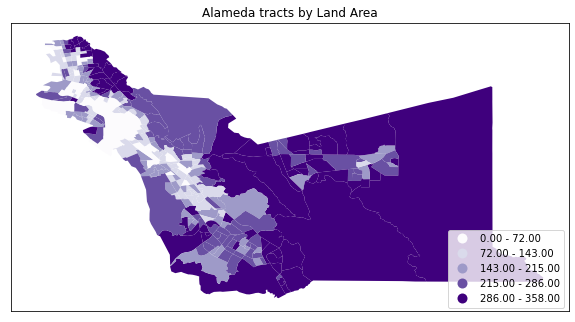

In [62]:
ax = alameda_tract_geo.plot(figsize=(10,10), column='income', cmap='Purples', scheme='quantiles', legend=True)
ax.set(xticks=[], yticks=[]) #removes axes
ax.set_title("Alameda tracts by Land Area", fontsize='large')
#add the legend and specify its location
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.0,0.3))
plt.savefig("Alameda_tracts.png", bbox_inches='tight')

# Testing GeoDataFrames

In [64]:
alameda_tract_geo.geometry.name

'geometry'

In [65]:
alameda_tract_geo['geometry'].head()

0    POLYGON ((-122.26807 37.84414, -122.26514 37.8...
1    POLYGON ((-122.28558 37.83978, -122.28319 37.8...
2    POLYGON ((-122.27861 37.82688, -122.26856 37.8...
3    POLYGON ((-122.27476 37.79883, -122.27127 37.8...
4    POLYGON ((-122.24717 37.78991, -122.24351 37.7...
Name: geometry, dtype: geometry

In [66]:
alameda_gdf = gpd.GeoDataFrame(geometry = alameda_tract_geo['geometry'], data = alameda_tract_geo['income'])

In [67]:
alameda_tract_geo['income'].min()

0.0

Text(0.5, 1.0, 'Alameda County, CA - Median Household Income by Census Tract')

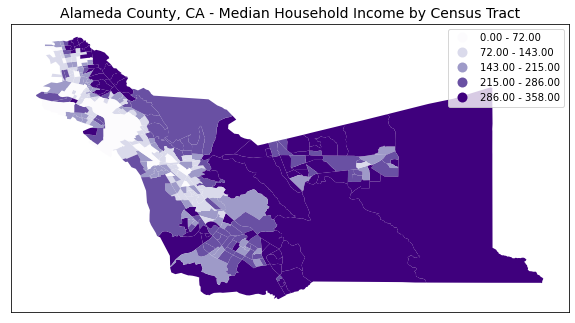

In [68]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal', xticks=[], yticks=[])
#alameda_gdf.plot(column= 'income', ax = ax)
alameda_gdf.plot(column= 'income', ax = ax, scheme='QUANTILES', cmap='Purples', legend=True)
plt.title('Alameda County, CA - Median Household Income by Census Tract', size = 14)

## The file Tract_flows.csv has the flows between FIPS in the US

It was extracted from the CTPP community survey
https://www.fhwa.dot.gov/planning/census_issues/ctpp/data_products/2006-2010_tract_flows/index.cfm

This link: https://davidabailey.com/articles/Creating-a-Four-step-Transportation-Model-in-Python
        makes a flow model in Python using population and employment data.
        Note the model tries to resemble the data of the link above.
        It has a GitHub repositoru with the code
        

I am sharing the file FourStepModel_PartI.ipynb here. 
The time consuming part is to have all the libraries installed.
Do not run the code without having everything installed, and the keys for the APIs